# Number of inhabitants per district first check

We will try to find significant correlations between historical episodes (2008 on for the economical crisis) and any district in Madrid by analysing drastic or significant changes in the census.

We will evaluate this correlation for different segments in the population of Madrid such as nationality (spanish or not), gender and age range.

The census data is considered for all Decembers between 2003 and 2016 including July number for 2017.

In [52]:
import pandas as pd
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt  
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline

In [53]:
def extract_header(df, n_rows):
    df_clean = df.iloc[n_rows:].copy()
    header = df.iloc[:n_rows].copy()
    return header, df_clean

def extract_footer(df, n_rows):
    df_clean = df.iloc[:-n_rows].copy()
    footer = df.iloc[-n_rows:].copy()
    return footer, df_clean

def index_to_column(df, index_levels):
    return df.reset_index(level=index_levels)

def split_dataframes_by_index_pattern(df, pattern, clean=True):
    list_df = []
    # map each bunch of data with an id and map it to the string that contain the pattern
    new_col_values = df.index.str.contains(pattern)
    df['new_df'] = new_col_values.astype(int)
    df['new_df'] = df['new_df'].cumsum()
    new_col = df.index[new_col_values]
    
    # create a mapper series with index integers as new_df and values as content of pattern
    new_col = pd.Series(new_col, index=range(1,len(new_col)+1))
    df['new_df'] = df['new_df'].map(new_col)
    
    # clean rows that contain pattern
    if clean:
        df = df[~(new_col_values)].copy()
    return df, new_col 

def re_define_column_names(df, list_columns):
    df.columns = list_columns
    return df

def add_column(df, column_name, value):
    df[column_name] = value
    return df

In [54]:
# Special variables for census data cleaning
# extract only those records with index of interst
idx_to_col_id = 1
list_str_patterns = ['TODOS','Total','0 - 4','5 - 9','10 - 14','15 - 19',
 '20 - 24','25 - 29','30 - 34','35 - 39','40 - 44','45 - 49','50 - 54',
 '55 - 59','60 - 64','65 - 69','70 - 74','75 - 79','80 - 84','85 - 89',
 '90 - 94','95 - 99','100 o más']
n_rows_header = 4
n_rows_footer = 4
district_pattern_id = 'TODOS'
list_columns = ['spanish_men', 'spanish_women', 'spanish_total', 'foreign_men', 'foreign_women', 
                'foreign_total', 'men_total', 'women_total', 'total', 'district']
path = '../data_sources/input/'
census_files = [f for f in listdir(path) if isfile(join(path, f))]

In [55]:
df_list = []
for file in census_files:
    df = pd.read_excel(path + file)
    print(path + file)
    
    # leave only as index what is an index
    df = index_to_column(df, idx_to_col_id)
    
    # clean header and footer
    header, df_clean = extract_header(df, n_rows_header)
    footer, df_clean = extract_footer(df_clean, n_rows_footer)
    
    # extract districts as a new column
    df, distrits = split_dataframes_by_index_pattern(df_clean, district_pattern_id, True)
    df = re_define_column_names(df, list_columns)
    
    # add new columns that identify file data
    date = header['level_1'][0]
    year = date.split('-')[2]
    print(year, date)
    df = add_column(df, 'date', date)
    df = add_column(df, 'year', year)
    
    df_list.append(df)
    
df_total = pd.concat(df_list)    

../data_sources/input/madrid_censo_distrito_07_2017.xls
2017 01-01-2017
../data_sources/input/madrid_censo_distrito_12_2004.xls
2004 01-01-2004
../data_sources/input/madrid_censo_distrito_12_2005.xls
2005 01-01-2005
../data_sources/input/madrid_censo_distrito_12_2006.xls
2006 01-01-2006
../data_sources/input/madrid_censo_distrito_12_2007.xls
2007 01-01-2007
../data_sources/input/madrid_censo_distrito_12_2008.xls
2008 01-01-2008
../data_sources/input/madrid_censo_distrito_12_2009.xls
2009 01-01-2009
../data_sources/input/madrid_censo_distrito_12_2010.xls
2010 01-01-2010
../data_sources/input/madrid_censo_distrito_12_2011.xls
2011 01-01-2011
../data_sources/input/madrid_censo_distrito_12_2012.xls
2012 01-01-2012
../data_sources/input/madrid_censo_distrito_12_2013.xls
2013 01-01-2013
../data_sources/input/madrid_censo_distrito_12_2014.xls
2014 01-01-2014
../data_sources/input/madrid_censo_distrito_12_2015.xls
2015 01-01-2015
../data_sources/input/madrid_censo_distrito_12_2016.xls
2016 01-

In [57]:
df_total.to_csv('complete_clean_census_madrid.csv', encoding='utf-8')

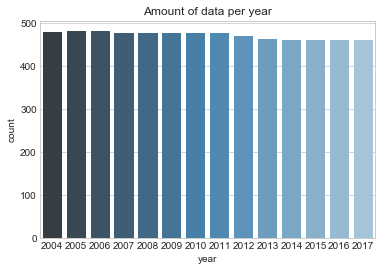

In [59]:
count_year = df_total.loc[:, ['date','year']].rename(columns={'date':'count'}).groupby(['year']).count().reset_index()
sns.set_style("whitegrid")
ax = sns.barplot(x='year', y='count', data=count_year, palette="Blues_d")
ax.set_title('Amount of data per year')

In [7]:
df_total.head(2)

,spanish_men,spanish_women,spanish_total,foreign_men,foreign_women,foreign_total,men_total,women_total,total,district,date,year
Total,50710,53512,104222,15249,12951,28200,65959,66463,132422,CENTRO / TODOS,01-01-2017,2017
0 - 4,1565,1544,3109,465,427,892,2030,1971,4001,CENTRO / TODOS,01-01-2017,2017


### 1. Evaluate the total number of inhabitants per district with respect to 2004

In [8]:
overall_total = df_total.ix['Total',['total', 'district', 'year']]

In [76]:
overall_ratio_2004 = []
for index, df_d in overall_total.groupby(['district']):
    reference = df_d[df_d['year'] == '2004']['total'][0]
    df_d['ratio_2004'] = df_d['total'].apply(lambda x: x / reference)
    overall_ratio_2004.append(df_d)
overall_ratio_2004 = pd.concat(overall_ratio_2004)

/Users/celsadiaz/.pyenv/versions/3.6.2/envs/visualizations/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


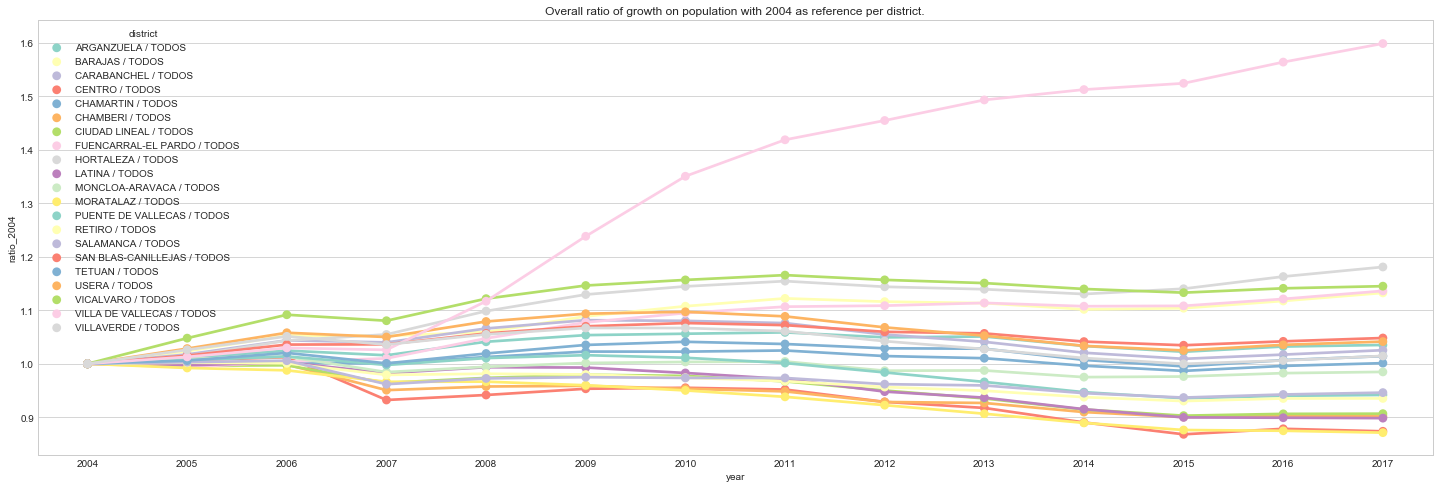

In [43]:
plt.figure(figsize=(25,8))
ax = sns.pointplot(x="year", y="ratio_2004", hue="district", data=overall_ratio_2004, palette="Set3")
ax.set_title("Overall ratio of growth on population with 2004 as reference per district.")

### 2. Evaluate the number of inhabitants between 60 - on per district with respect to 2004

In [11]:
old_total = df_total.ix[['80 - 84','85 - 89',
 '90 - 94','95 - 99','100 o más'],['total', 'district', 'year']]

In [12]:
old_ratio_2004 = []
for index, df_d in old_total.groupby(['district']):
    df_d = df_d.groupby(['district','year']).sum().reset_index().copy()
    reference = df_d[df_d['year'] == '2004']['total'][0]
    df_d['ratio_2004'] = df_d['total'].apply(lambda x: x / reference)
    old_ratio_2004.append(df_d)
old_ratio_2004 = pd.concat(old_ratio_2004)

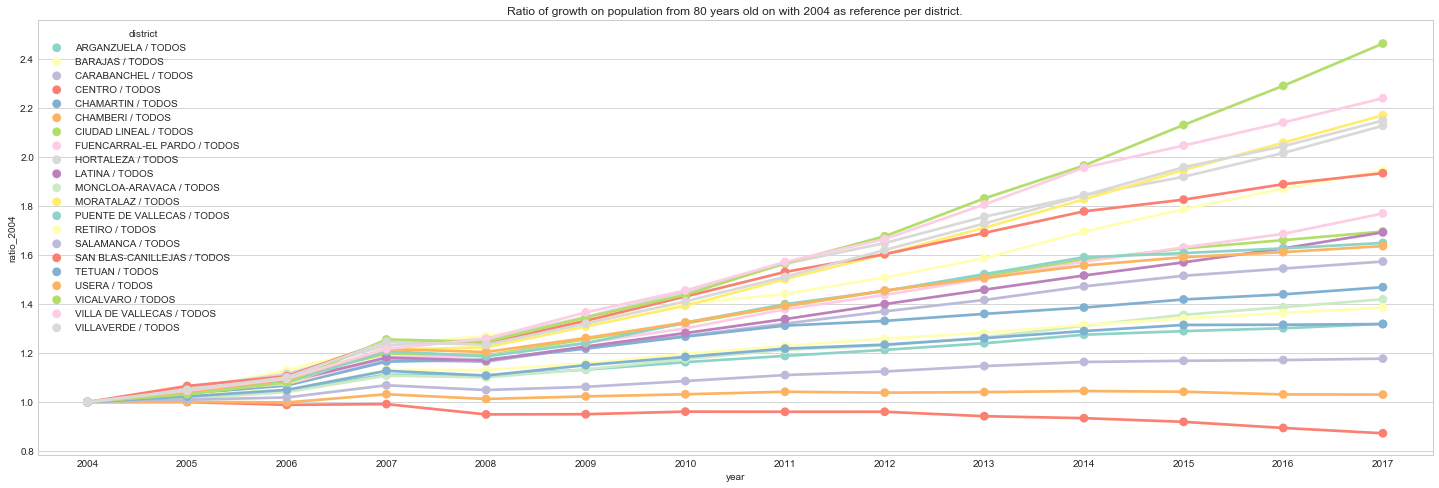

In [45]:
plt.figure(figsize=(25,8))
ax = sns.pointplot(x="year", y="ratio_2004", hue="district", data=old_ratio_2004, palette="Set3")
ax.set_title("Ratio of growth on population from 80 years old on with 2004 as reference per district.")

### 3. Evaluate the spanish number of inhabitants between 60 - on per district with respect to 2004

In [14]:
spanish_old_total = df_total.ix[['80 - 84','85 - 89',
 '90 - 94','95 - 99','100 o más'],['spanish_total', 'district', 'year']]

In [15]:
spanish_old_ratio_2004 = []
for index, df_d in spanish_old_total.groupby(['district']):
    df_d = df_d.groupby(['district','year']).sum().reset_index().copy()
    reference = df_d[df_d['year'] == '2004']['spanish_total'][0]
    df_d['ratio_2004'] = df_d['spanish_total'].apply(lambda x: x / reference)
    spanish_old_ratio_2004.append(df_d)
spanish_old_ratio_2004 = pd.concat(spanish_old_ratio_2004)

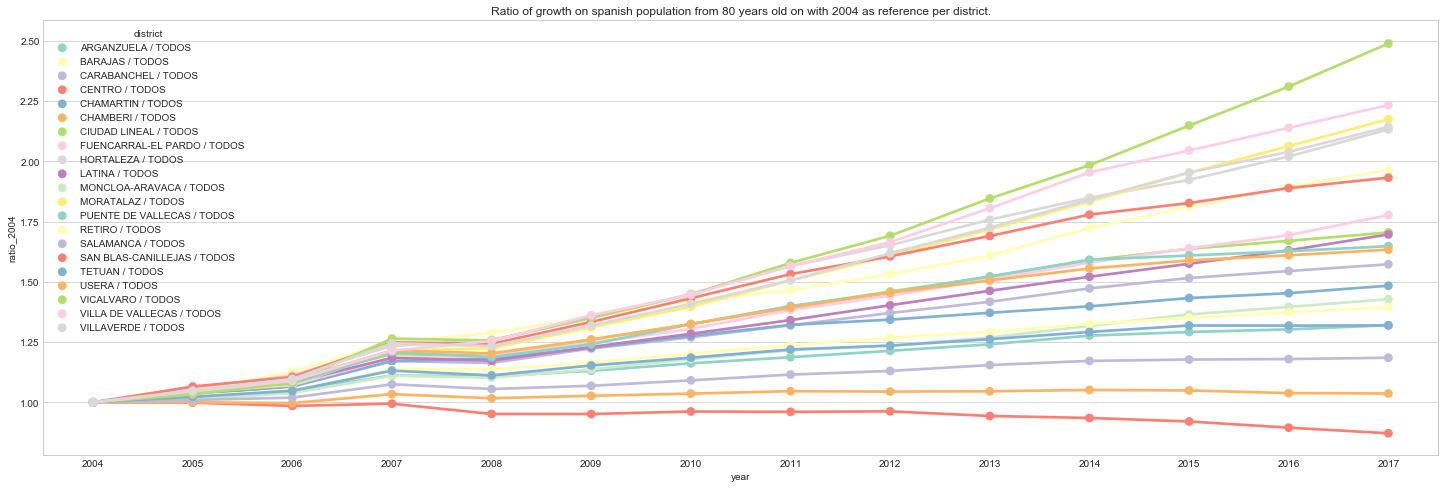

In [47]:
plt.figure(figsize=(25,8))
ax = sns.pointplot(x="year", y="ratio_2004", hue="district", data=spanish_old_ratio_2004, palette="Set3")
ax.set_title("Ratio of growth on spanish population from 80 years old on with 2004 as reference per district.")

### 4. Evaluate the femenine of inhabitants between 60 - on per district with respect to 2004

In [17]:
women_old_total = df_total.ix[['80 - 84','85 - 89',
 '90 - 94','95 - 99','100 o más'],['women_total', 'district', 'year']]

In [18]:
women_old_ratio_2004 = []
for index, df_d in women_old_total.groupby(['district']):
    # sum total old people
    #import pdb; pdb.set_trace()
    df_d = df_d.groupby(['district','year']).sum().reset_index().copy()
    reference = df_d[df_d['year'] == '2004']['women_total'][0]
    df_d['ratio_2004'] = df_d['women_total'].apply(lambda x: x / reference)
    women_old_ratio_2004.append(df_d)
women_old_ratio_2004 = pd.concat(women_old_ratio_2004)

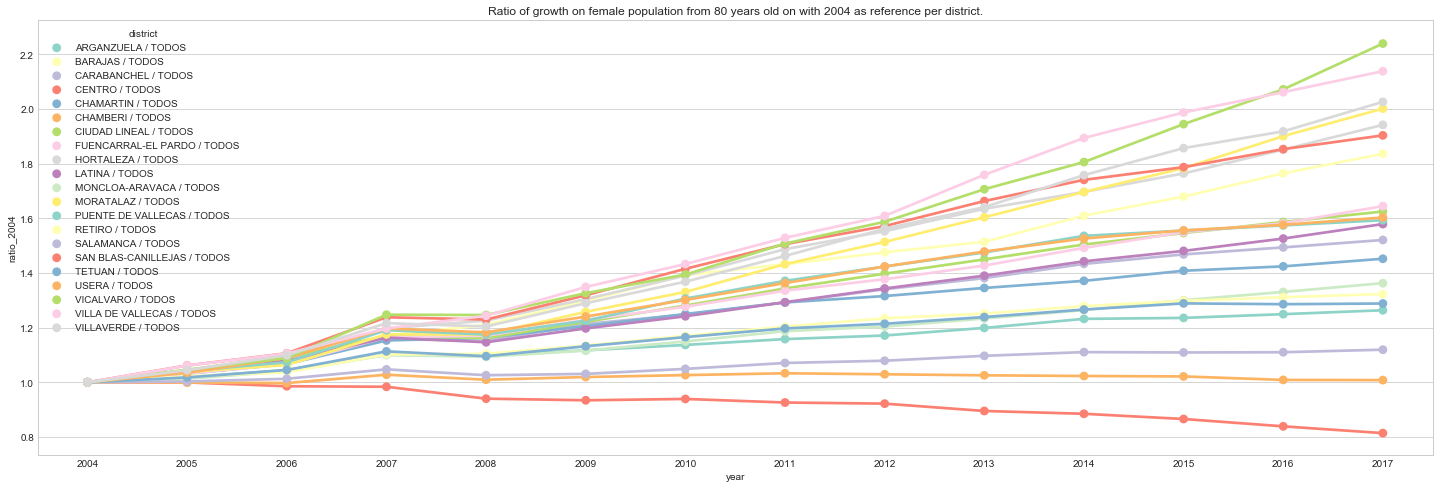

In [48]:
plt.figure(figsize=(25,8))
ax = sns.pointplot(x="year", y="ratio_2004", hue="district", data=women_old_ratio_2004, palette="Set3")
ax.set_title("Ratio of growth on female population from 80 years old on with 2004 as reference per district.")

### 5. Evaluate the foreinger inhabitants per district with respect to 2004

In [20]:
foreign_total = df_total.ix[['Total'],['foreign_total', 'district', 'year']]

In [21]:
foreign_ratio_2004 = []
for index, df_d in foreign_total.groupby(['district']):
    df_d = df_d.groupby(['district','year']).sum().reset_index().copy()
    reference = df_d[df_d['year'] == '2004']['foreign_total'][0]
    df_d['ratio_2004'] = df_d['foreign_total'].apply(lambda x: x / reference)
    foreign_ratio_2004.append(df_d)
foreign_ratio_2004 = pd.concat(foreign_ratio_2004)

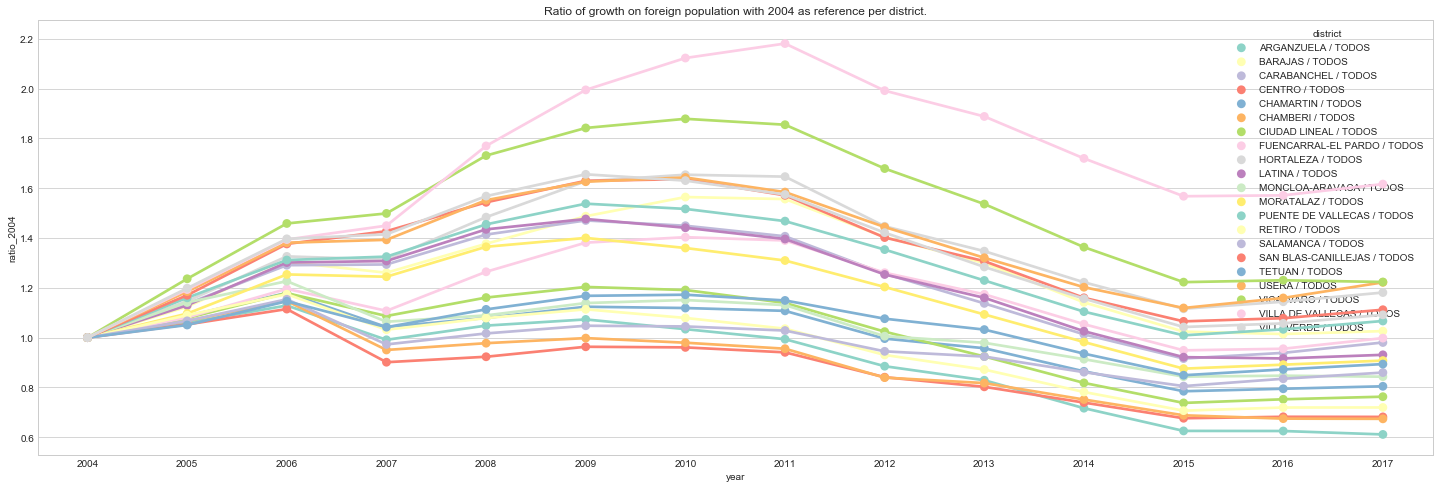

In [50]:
plt.figure(figsize=(25,8))
ax = sns.pointplot(x="year", y="ratio_2004", hue="district", data=foreign_ratio_2004, palette="Set3")
ax.set_title("Ratio of growth on foreign population with 2004 as reference per district.")

### 6. Evaluate correlation between ages and segments in san blas-canillejas for the different years

In [23]:
corr_df = df_total[(df_total['year'].isin(['2008','2009','2010','2011','2012','2013','2014','2015'])) & 
                   (df_total['district'].isin(['SAN BLAS-CANILLEJAS / TODOS']))].copy()
corr_df = corr_df[~(corr_df.index.isin(['Total','No Consta']))].copy()

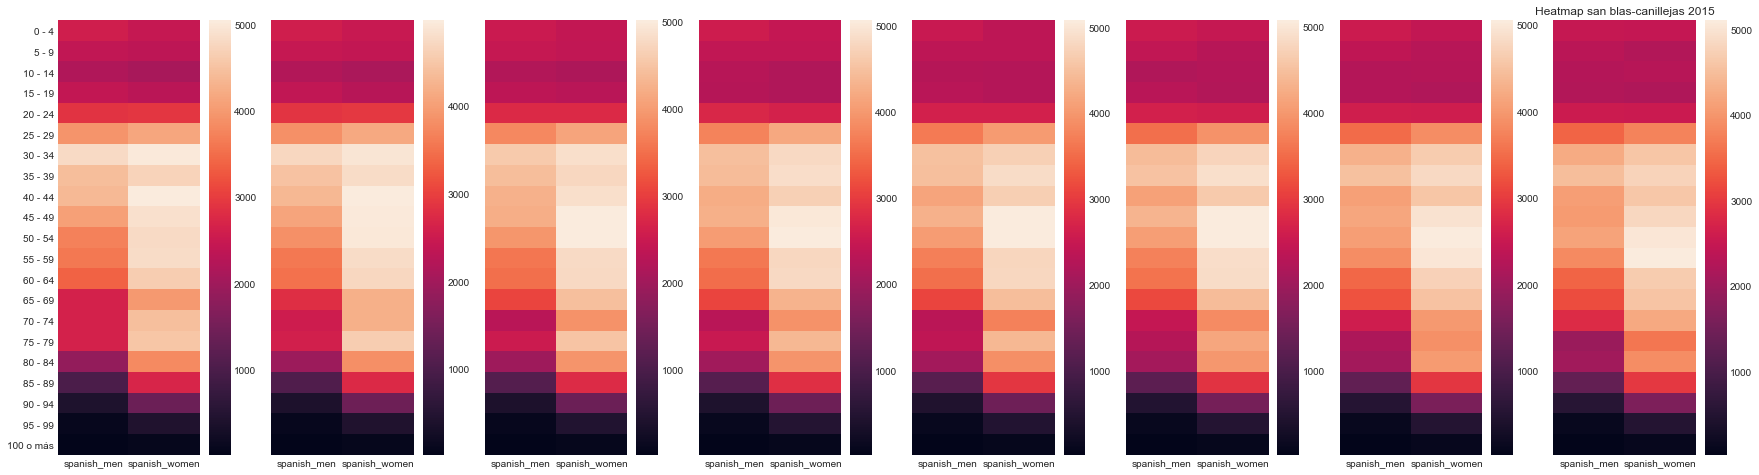

In [60]:
fig, axs = plt.subplots(ncols=8, sharex='row', sharey='row', figsize=(30, 8))
idx = 0
for index, df_i in corr_df.groupby(['year']):
    foo = df_i.loc[:, ['spanish_men', 'spanish_women']].astype(float)
    
    plt.title('Heatmap san blas-canillejas ' + df_i.iloc[0]['year'])
    sns.heatmap(foo, xticklabels=1, yticklabels=1, ax=axs[idx])
    idx += 1    
fig.subplots_adjust(hspace=0)

### 7. Evaluate correlation between ages and segments in chamberi for the different years

In [25]:
corr_df = df_total[(df_total['year'].isin(['2008','2009','2010','2011','2012','2013','2014','2015'])) & 
                   (df_total['district'].isin(['CHAMBERI / TODOS']))].copy()
corr_df = corr_df[~(corr_df.index.isin(['Total','No Consta']))].copy()

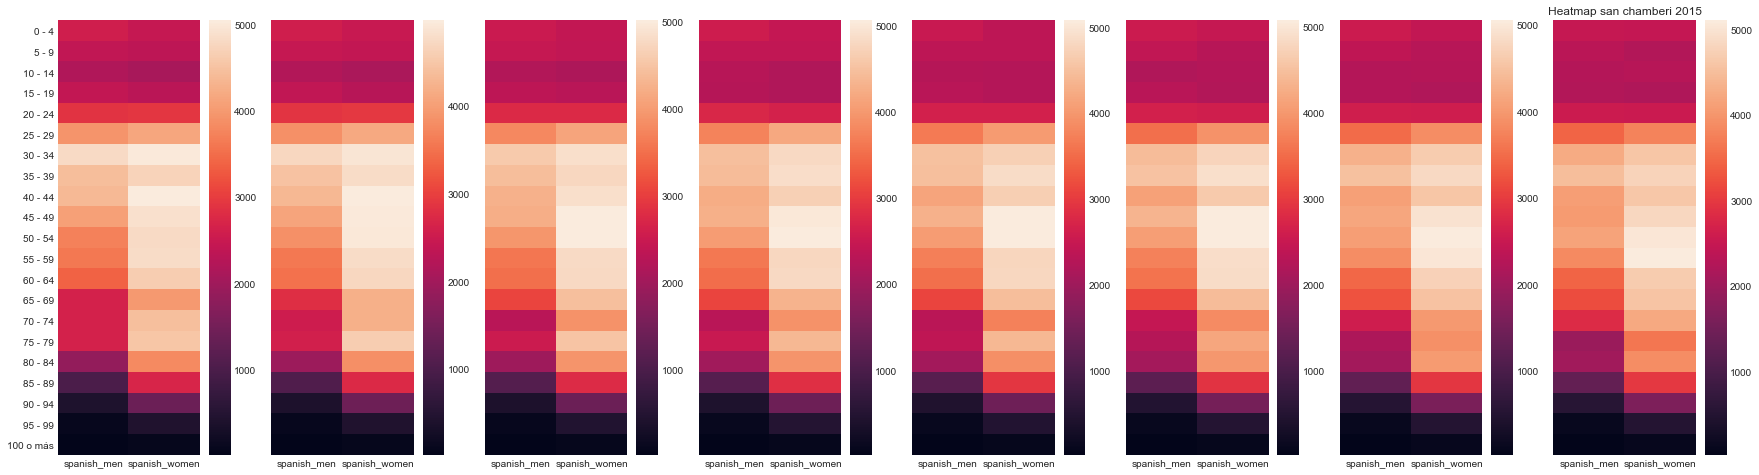

In [61]:
fig, axs = plt.subplots(ncols=8, sharex='row', sharey='row', figsize=(30, 8))
idx = 0
for index, df_i in corr_df.groupby(['year']):
    foo = df_i.loc[:, ['spanish_men', 'spanish_women']].astype(float)
    
    plt.title('Heatmap san chamberi ' + df_i.iloc[0]['year'])
    sns.heatmap(foo, xticklabels=1, yticklabels=1, ax=axs[idx])
    idx += 1    
fig.subplots_adjust(hspace=0)

### 8. Evaluate correlation between ages and segments in villa de vallecas for the different years

In [27]:
corr_df = df_total[(df_total['year'].isin(['2008','2009','2010','2011','2012','2013','2014','2015'])) & 
                   (df_total['district'].isin(['VILLA DE VALLECAS / TODOS']))].copy()
corr_df = corr_df[~(corr_df.index.isin(['Total','No Consta']))].copy()

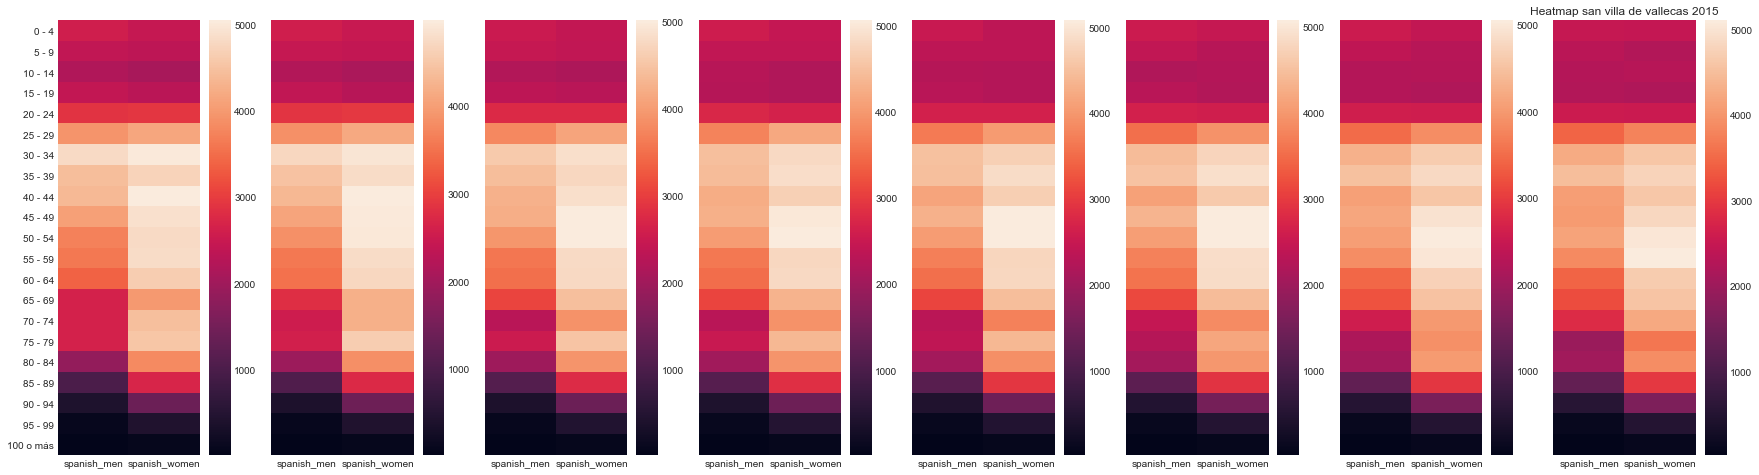

In [62]:
fig, axs = plt.subplots(ncols=8, sharex='row', sharey='row', figsize=(30, 8))
idx = 0
for index, df_i in corr_df.groupby(['year']):
    foo = df_i.loc[:, ['spanish_men', 'spanish_women']].astype(float)
    
    plt.title('Heatmap san villa de vallecas ' + df_i.iloc[0]['year'])
    sns.heatmap(foo, xticklabels=1, yticklabels=1, ax=axs[idx])
    idx += 1    
fig.subplots_adjust(hspace=0)

### 9. Evaluate correlation between ages and segments in puente de vallecas for the different years

In [29]:
corr_df = df_total[(df_total['year'].isin(['2008','2009','2010','2011','2012','2013','2014','2015'])) & 
                   (df_total['district'].isin(['PUENTE DE VALLECAS / TODOS']))].copy()
corr_df = corr_df[~(corr_df.index.isin(['Total','No Consta']))].copy()

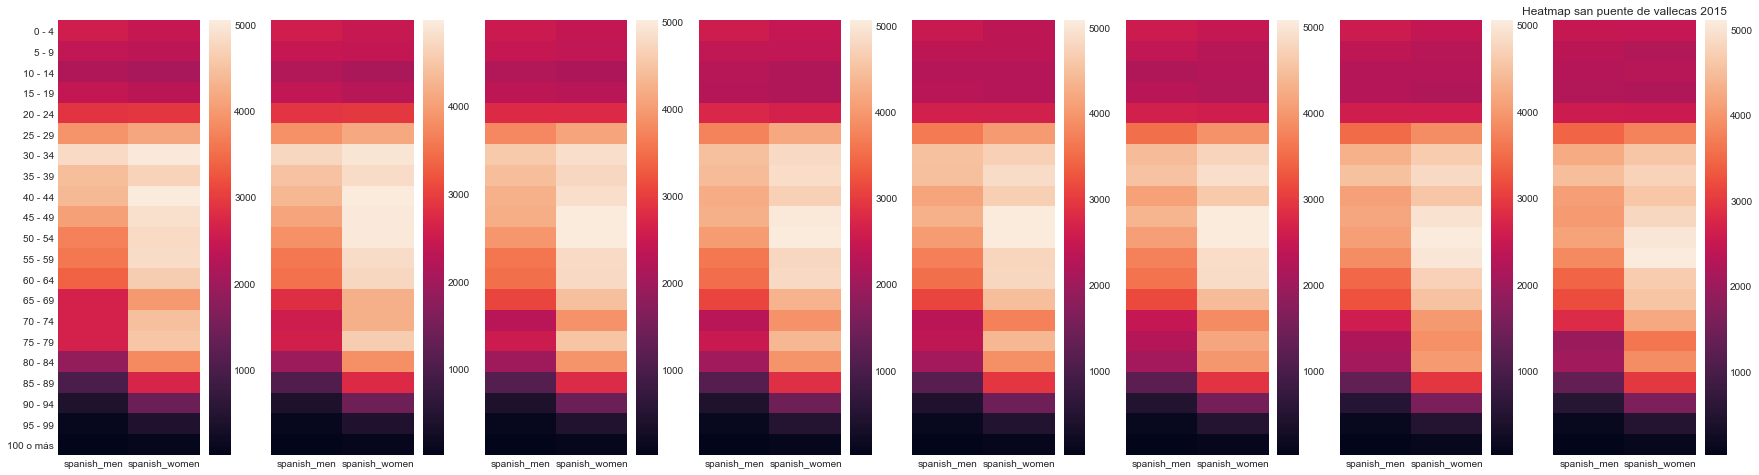

In [63]:
fig, axs = plt.subplots(ncols=8, sharex='row', sharey='row', figsize=(30, 8))
idx = 0
for index, df_i in corr_df.groupby(['year']):
    foo = df_i.loc[:, ['spanish_men', 'spanish_women']].astype(float)
    
    plt.title('Heatmap san puente de vallecas ' + df_i.iloc[0]['year'])
    sns.heatmap(foo, xticklabels=1, yticklabels=1, ax=axs[idx])
    idx += 1    
fig.subplots_adjust(hspace=0)

### 10. Evaluate correlation between ages and segments in villaverde for the different years

In [31]:
corr_df = df_total[(df_total['year'].isin(['2008','2009','2010','2011','2012','2013','2014','2015'])) & 
                   (df_total['district'].isin(['VILLAVERDE / TODOS']))].copy()
corr_df = corr_df[~(corr_df.index.isin(['Total','No Consta']))].copy()

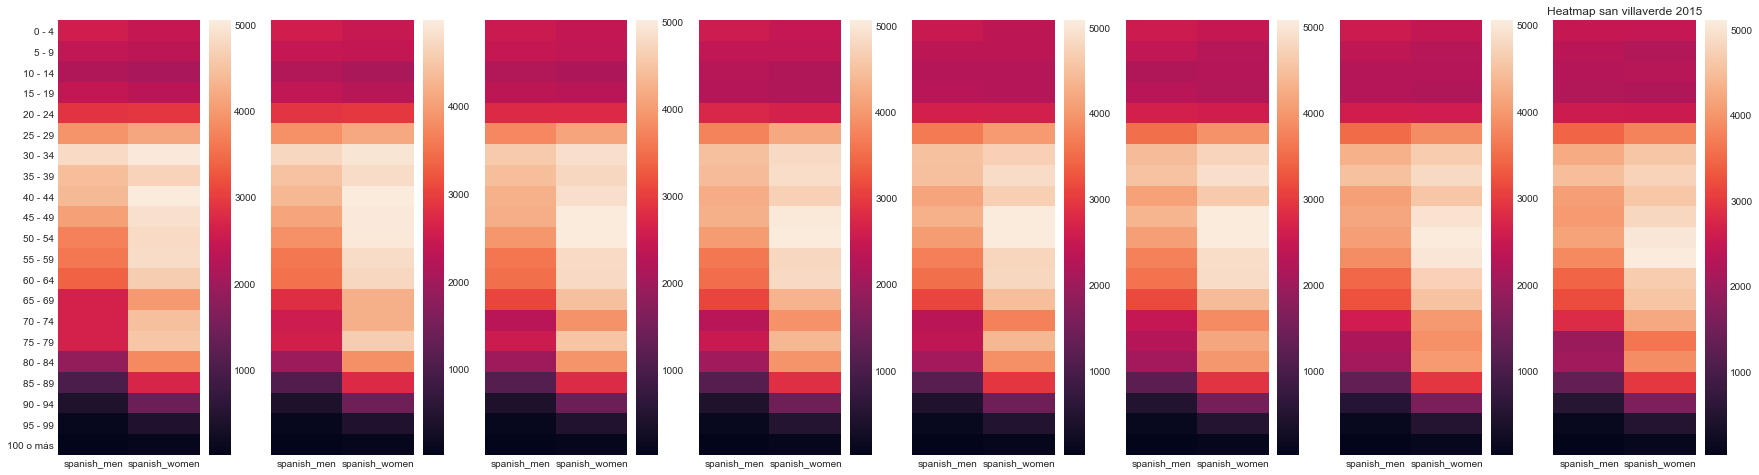

In [64]:
fig, axs = plt.subplots(ncols=8, sharex='row', sharey='row', figsize=(30, 8))
idx = 0
for index, df_i in corr_df.groupby(['year']):
    foo = df_i.loc[:, ['spanish_men', 'spanish_women']].astype(float)
    
    plt.title('Heatmap san villaverde ' + df_i.iloc[0]['year'])
    sns.heatmap(foo, xticklabels=1, yticklabels=1, ax=axs[idx])
    idx += 1    
fig.subplots_adjust(hspace=0)

### 11. Evaluate correlation between ages and segments in carabanchel for the different years

In [33]:
corr_df = df_total[(df_total['year'].isin(['2008','2009','2010','2011','2012','2013','2014','2015'])) & 
                   (df_total['district'].isin(['CARABANCHEL / TODOS']))].copy()
corr_df = corr_df[~(corr_df.index.isin(['Total','No Consta']))].copy()

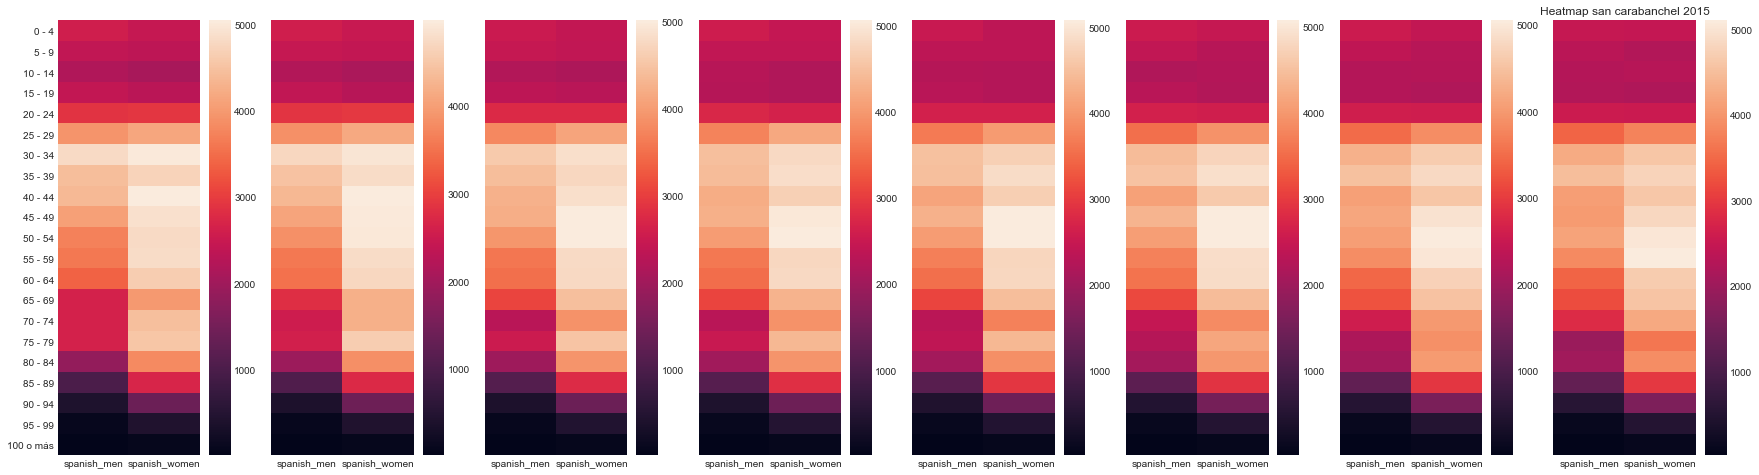

In [65]:
fig, axs = plt.subplots(ncols=8, sharex='row', sharey='row', figsize=(30, 8))
idx = 0
for index, df_i in corr_df.groupby(['year']):
    foo = df_i.loc[:, ['spanish_men', 'spanish_women']].astype(float)
    
    plt.title('Heatmap san carabanchel ' + df_i.iloc[0]['year'])
    sns.heatmap(foo, xticklabels=1, yticklabels=1, ax=axs[idx])
    idx += 1    
fig.subplots_adjust(hspace=0)

### 12. Evaluate correlation between ages and segments in salamanca for the different years

In [35]:
corr_df = df_total[(df_total['year'].isin(['2008','2009','2010','2011','2012','2013','2014','2015'])) & 
                   (df_total['district'].isin(['SALAMANCA / TODOS']))].copy()
corr_df = corr_df[~(corr_df.index.isin(['Total','No Consta']))].copy()

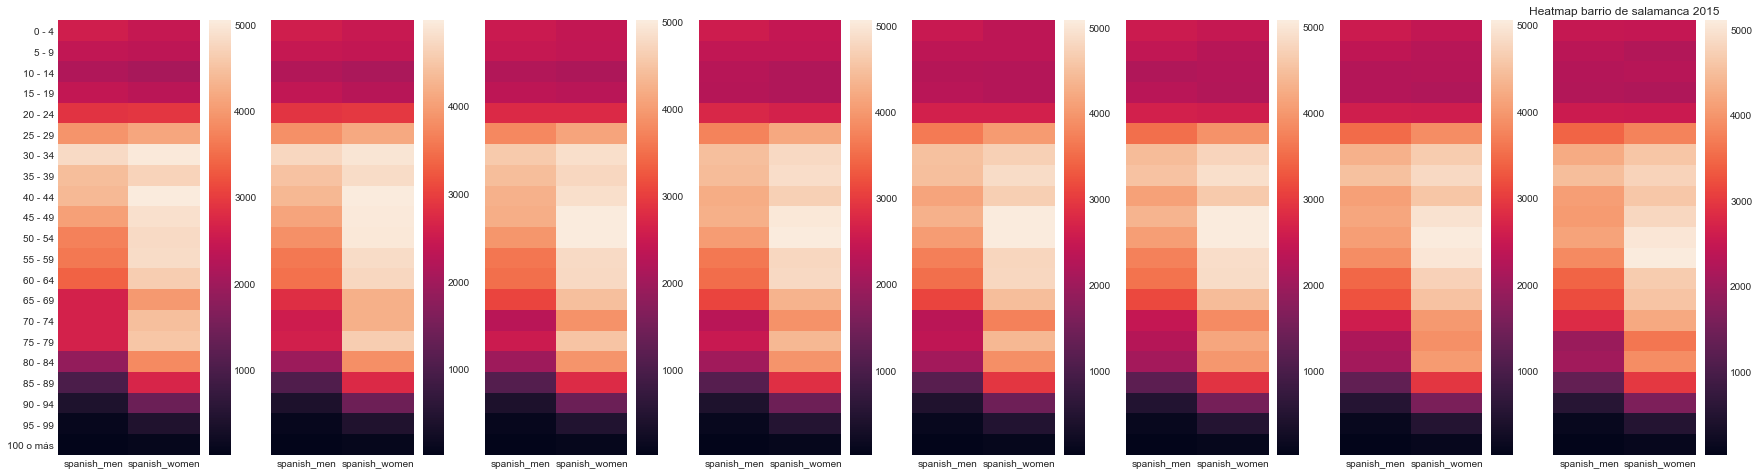

In [66]:
fig, axs = plt.subplots(ncols=8, sharex='row', sharey='row', figsize=(30, 8))
idx = 0
for index, df_i in corr_df.groupby(['year']):
    foo = df_i.loc[:, ['spanish_men', 'spanish_women']].astype(float)
    
    plt.title('Heatmap barrio de salamanca ' + df_i.iloc[0]['year'])
    sns.heatmap(foo, xticklabels=1, yticklabels=1, ax=axs[idx])
    idx += 1    
fig.subplots_adjust(hspace=0)

### 13. Conclusions

To many parameters to make conclusions from simple visualization.

Visualization main insights:
* There is not a clear difference between spaniards' and foreigners' census patterns in terms of age ranges population
* There is a clear difference between male and female in the population levels mainly from 20 on. This pattern has been observed in spaniards and foreigners
* There are differences on population rates between neighborhoods and variations during the crisis are in most cases smooth.

What to do next:
* We need to normalize the data per year in order to discard general population trends 
* We need to extract variation on population by segments and normalize it. Extract only relevant changes that occur out of a 95% condifence level. 